In [1]:
import pickle
import numpy as np
import pandas as pd
from data import Stock
import matplotlib.cm as cm
from analysis import Analysis
import matplotlib.pyplot as plt
from hidden_markov_model import Hidden_Markov_Model

#### Data Retrieval And Display

In [2]:
sa40 = Stock('JTOPI', pd.read_csv('2015_2025_Historical_Data.csv'))
analysis = Analysis()

In [3]:
sa40.series_data

,Date,Price,Open,High,Low,Vol.,Return,Log_Return
1,2015-01-05,41990.24,43696.74,43882.81,41990.24,81.67,-0.039053,-0.039836
2,2015-01-06,42747.37,41990.24,42747.37,41983.39,78.48,0.018031,0.017870
3,2015-01-07,43086.35,42747.37,43159.91,42376.08,63.80,0.007930,0.007899
4,2015-01-08,43670.79,43086.35,43670.79,43020.22,76.25,0.013564,0.013473
5,2015-01-09,42994.58,43670.79,43785.33,42994.58,100.66,-0.015484,-0.015605
...,...,...,...,...,...,...,...,...
2494,2024-12-23,76067.93,75888.86,76277.36,75490.51,69.16,0.002360,0.002357
2495,2024-12-24,76320.99,76067.93,76588.19,75940.86,20.99,0.003327,0.003321
2496,2024-12-27,76197.46,76320.99,76603.50,75871.35,67.81,-0.001619,-0.001620
2497,2024-12-30,75427.05,76197.46,76221.20,75249.61,70.26,-0.010111,-0.010162


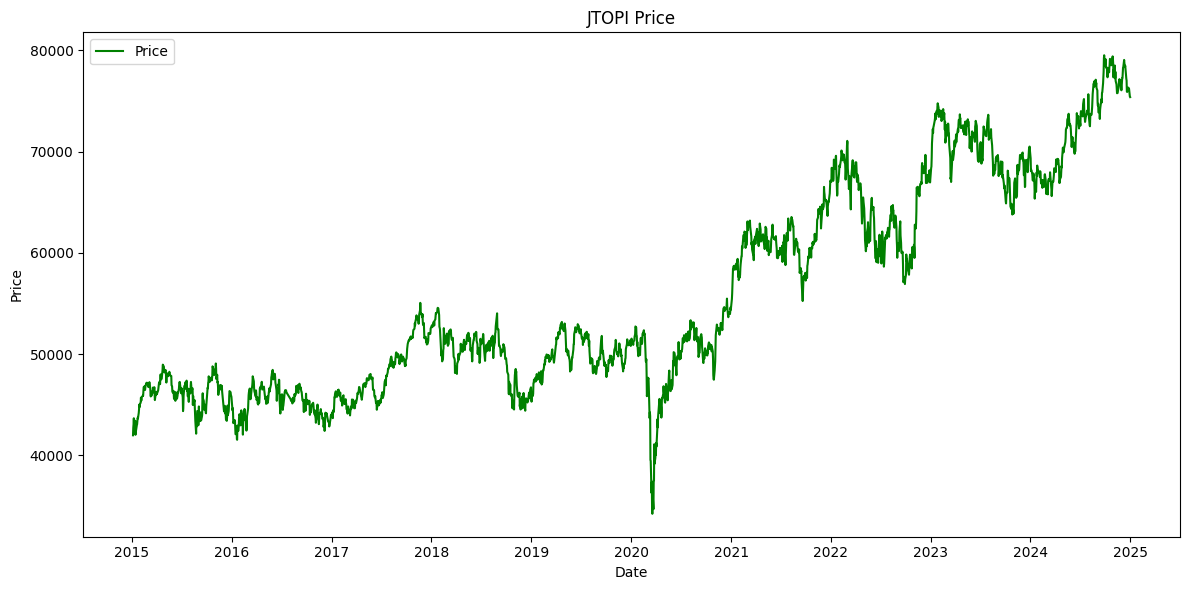

In [4]:
analysis.price_plot(sa40, 'Price')

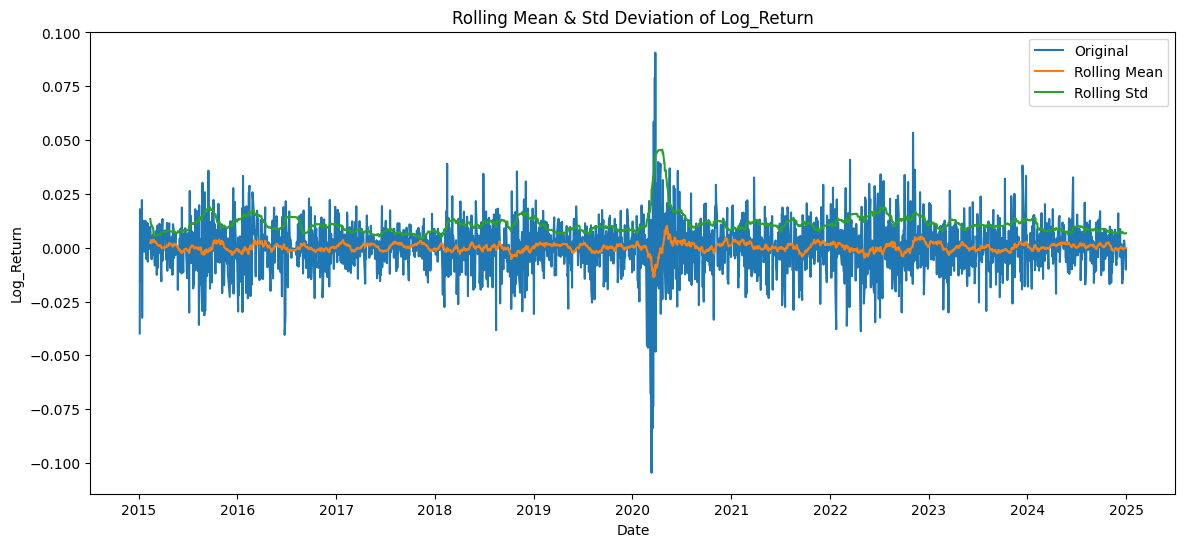

In [5]:
analysis.rolling_plot(sa40, 'Log_Return')

#### Two-State Model Specification And Training

In [6]:
two_state_model = Hidden_Markov_Model(sa40.series_data['Log_Return'].to_numpy(), 2)
two_state_model.baum_welch_algorithm(0.00001, 100)

Iteration 1 . . . Log-Likelihood = 7408.007491431229
Iteration 2 . . . Log-Likelihood = 7408.184647333635
Iteration 3 . . . Log-Likelihood = 7410.602939018509
Iteration 4 . . . Log-Likelihood = 7421.139441375301
Iteration 5 . . . Log-Likelihood = 7439.513920810334
Iteration 6 . . . Log-Likelihood = 7462.274720193471
Iteration 7 . . . Log-Likelihood = 7486.125428195774
Iteration 8 . . . Log-Likelihood = 7508.103362062328
Iteration 9 . . . Log-Likelihood = 7525.679506076329
Iteration 10 . . . Log-Likelihood = 7538.14607546942
Iteration 11 . . . Log-Likelihood = 7546.8104136552265
Iteration 12 . . . Log-Likelihood = 7553.458116627085
Iteration 13 . . . Log-Likelihood = 7559.262779662115
Iteration 14 . . . Log-Likelihood = 7564.75146721929
Iteration 15 . . . Log-Likelihood = 7570.102549449008
Iteration 16 . . . Log-Likelihood = 7575.353382702984
Iteration 17 . . . Log-Likelihood = 7580.490853595048
Iteration 18 . . . Log-Likelihood = 7585.483740433972
Iteration 19 . . . Log-Likelihood = 75

In [7]:
two_state_model.get_parameters()

==================================== 0 =====================================
Initial Probability: 1.0
Mean: -0.00028136517385409204
Variance: 0.00039343413416572894


==================================== 1 =====================================
Initial Probability: 1.55384e-319
Mean: 0.000376254937203797
Variance: 7.779202994269972e-05


Transition Matrix: [[0.92905053 0.07094947]
 [0.01779893 0.98220107]]
Log Likelihood: 7631.395100237298
Akaike Information Criterion: -15248.790200474596
Bayesian Information Criterion: -15208.129095327386


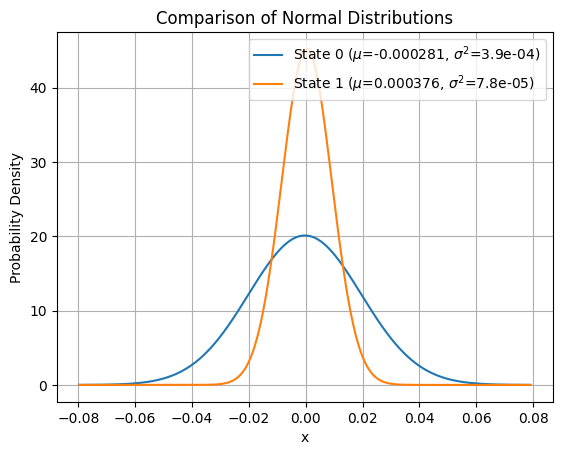

In [8]:
mean_array, variance_array = two_state_model.get_mean_variance()
analysis.plot_distributions(mean_array, variance_array)

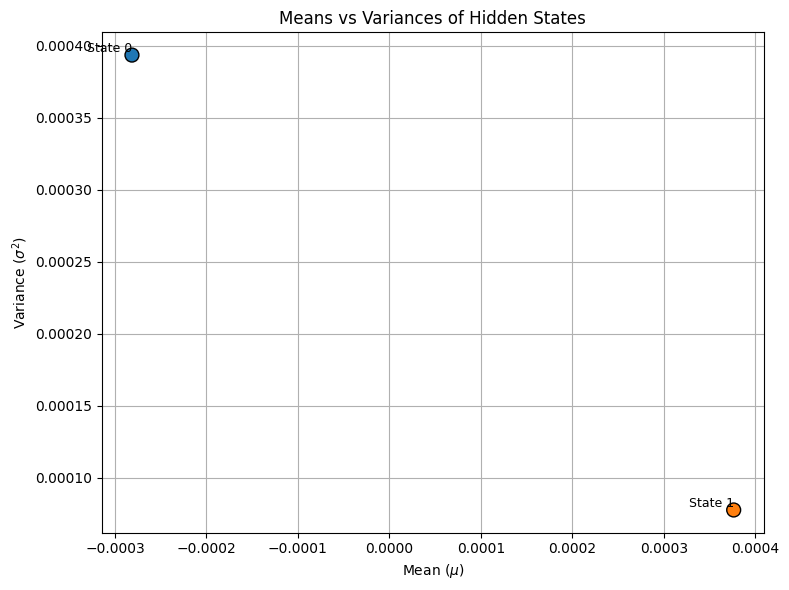

In [9]:
analysis.mean_variance_plot(mean_array, variance_array)

In [10]:
two_state_sequence = two_state_model.viterbi_algorithm()

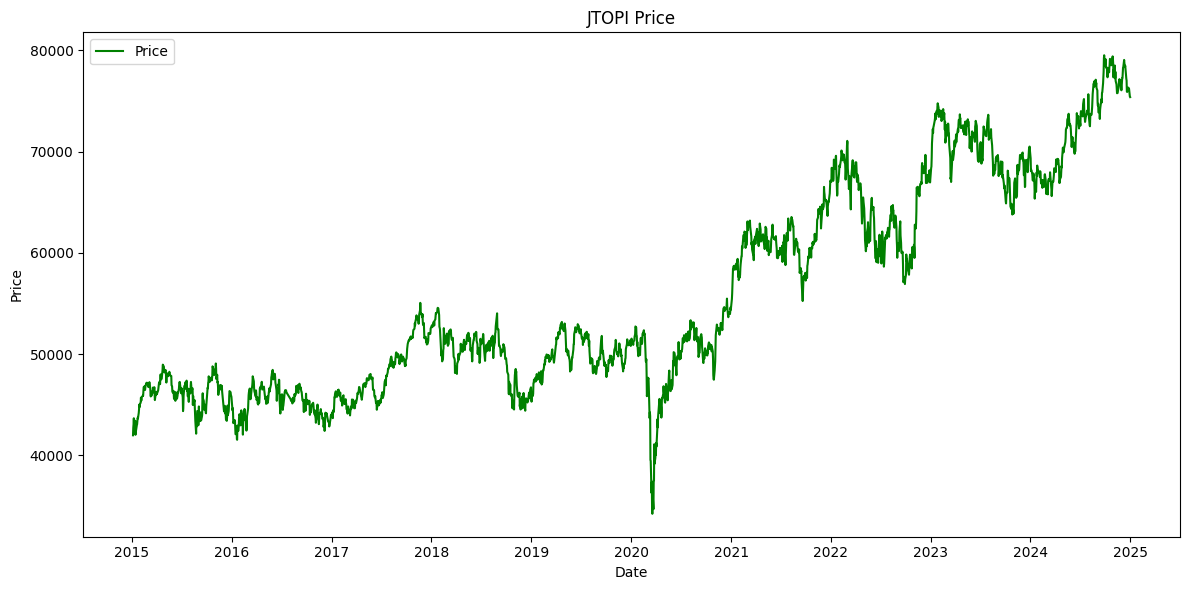

In [27]:
analysis.price_plot(sa40, 'Price')

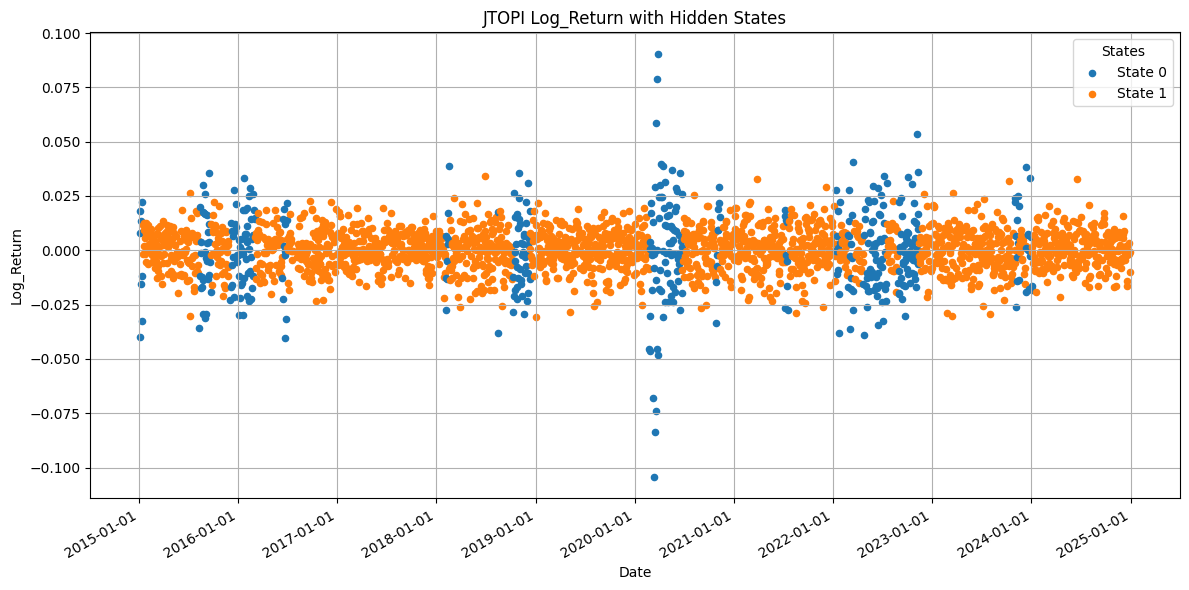

In [11]:
analysis.states_plot_points(sa40, 'Log_Return', two_state_sequence)

In [12]:
two_state_model.save_model('two_state_model')

HMM parameters saved to 'two_state_model.pkl'


#### Evaluate Model Against hmmlearn Model

In [15]:
import numpy as np
from hmmlearn import hmm

hmmlearn_two_state_model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100)
hmmlearn_two_state_model.fit(sa40.series_data['Log_Return'].to_numpy().reshape(-1,1))

GaussianHMM(n_components=2, n_iter=100)

In [16]:
'''
AIC & BIC benchmarking
'''

two_state_log_likelihood = hmmlearn_two_state_model.score(sa40.series_data['Log_Return'].to_numpy().reshape(-1,1))
def AIC(number_of_states, log_likelihood):
    number_of_parameters = (number_of_states * (number_of_states - 1)) + (2 * number_of_states) + (number_of_states - 1)
    return 2 * number_of_parameters - 2 * log_likelihood

def BIC(number_of_states, log_likelihood):
    number_of_parameters = (number_of_states * (number_of_states - 1)) + (2 * number_of_states) + (number_of_states - 1)
    return number_of_parameters * np.log(len(sa40.series_data['Log_Return'].to_numpy())) - 2 * log_likelihood

print(f'Akaike Information Criterion: {AIC(2, two_state_log_likelihood)}')
print(f'Bayesian Information Criterion: {BIC(2, two_state_log_likelihood)}')

Akaike Information Criterion: -15235.417562873092
Bayesian Information Criterion: -15194.756457725882


In [17]:
hmmlearn_two_state_sequence = hmmlearn_two_state_model.predict(sa40.series_data['Log_Return'].to_numpy().reshape(-1,1))

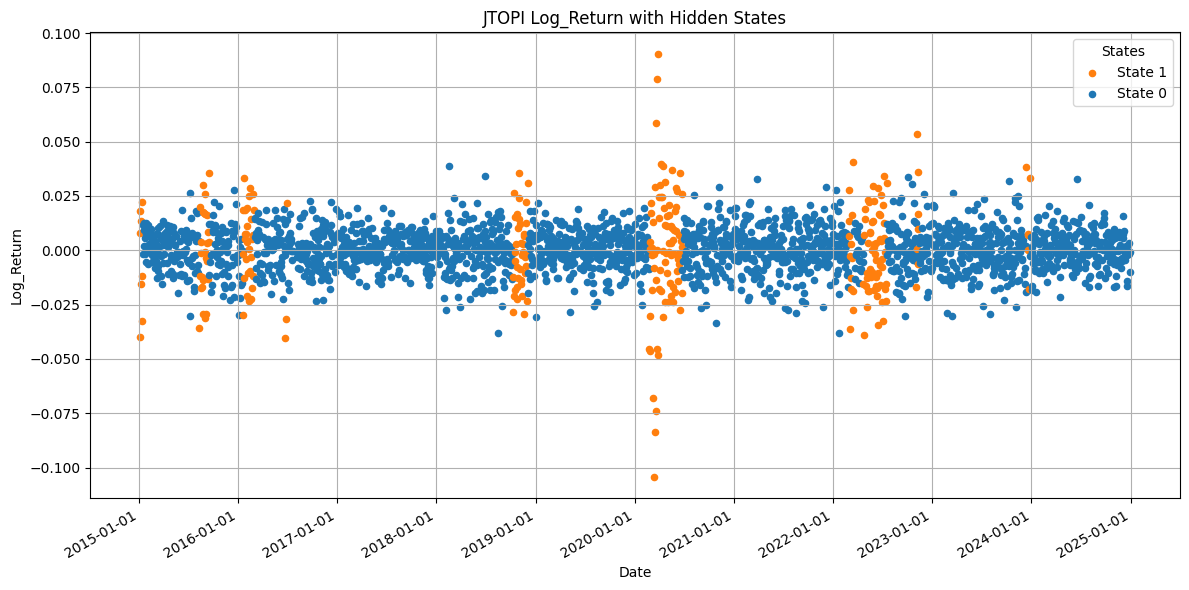

In [18]:
analysis.states_plot_points(sa40, 'Log_Return', hmmlearn_two_state_sequence)

#### Four-State Model Specification And Training

In [19]:
three_state_model = Hidden_Markov_Model(sa40.series_data['Log_Return'].to_numpy(), 3)
three_state_model.baum_welch_algorithm(0.00001, 100)

Iteration 1 . . . Log-Likelihood = 7408.015350220251
Iteration 2 . . . Log-Likelihood = 7408.292365044099
Iteration 3 . . . Log-Likelihood = 7414.009730685093
Iteration 4 . . . Log-Likelihood = 7472.278593545869
Iteration 5 . . . Log-Likelihood = 7540.816996561528
Iteration 6 . . . Log-Likelihood = 7566.271432090034
Iteration 7 . . . Log-Likelihood = 7574.184233346525
Iteration 8 . . . Log-Likelihood = 7578.435782740671
Iteration 9 . . . Log-Likelihood = 7582.10561205763
Iteration 10 . . . Log-Likelihood = 7585.674325784923
Iteration 11 . . . Log-Likelihood = 7589.177667112521
Iteration 12 . . . Log-Likelihood = 7592.586789086642
Iteration 13 . . . Log-Likelihood = 7595.8761852146035
Iteration 14 . . . Log-Likelihood = 7599.038975412421
Iteration 15 . . . Log-Likelihood = 7602.086712016278
Iteration 16 . . . Log-Likelihood = 7605.0417827687925
Iteration 17 . . . Log-Likelihood = 7607.927202041158
Iteration 18 . . . Log-Likelihood = 7610.756905630524
Iteration 19 . . . Log-Likelihood = 

In [20]:
three_state_model.get_parameters()

==================================== 0 =====================================
Initial Probability: 2.3897777958056713e-289
Mean: -0.00040957487432727346
Variance: 0.00013851192563883684


==================================== 1 =====================================
Initial Probability: 1.0
Mean: -0.0001960767413010298
Variance: 0.0005381027698119572


==================================== 2 =====================================
Initial Probability: 0.0
Mean: 0.0012031413089638864
Variance: 3.9979180476342704e-05


Transition Matrix: [[7.88533414e-01 1.01196327e-02 2.01346954e-01]
 [4.92155329e-02 9.47318466e-01 3.46600086e-03]
 [2.61457354e-01 4.68140123e-06 7.38537965e-01]]
Log Likelihood: 7654.411154122035
Akaike Information Criterion: -15280.82230824407
Bayesian Information Criterion: -15199.500097949649


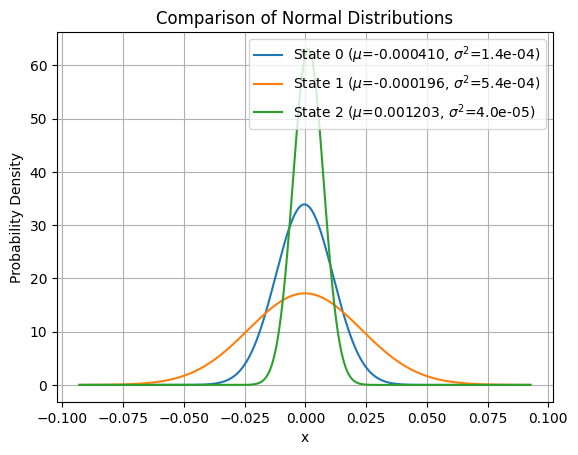

In [21]:
mean_array, variance_array = three_state_model.get_mean_variance()
analysis.plot_distributions(mean_array, variance_array)

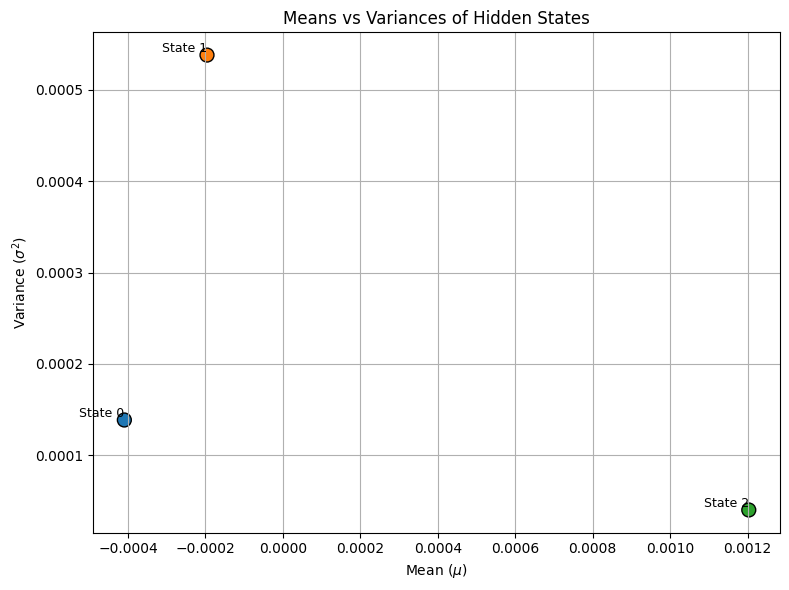

In [22]:
analysis.mean_variance_plot(mean_array, variance_array)

In [24]:
three_state_sequence = three_state_model.viterbi_algorithm()

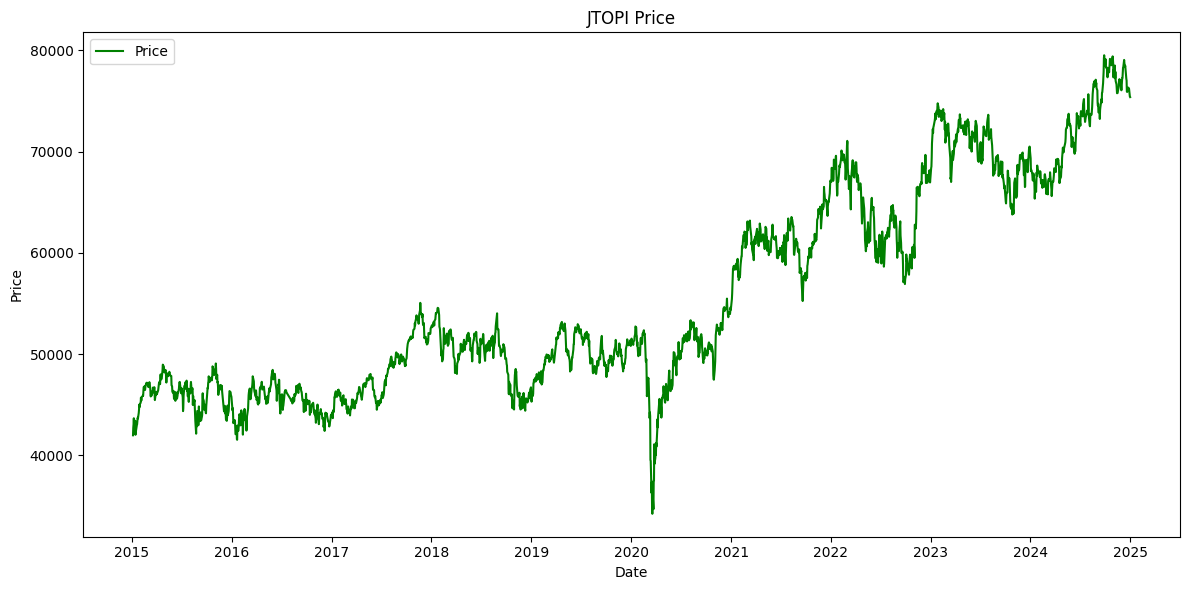

In [26]:
analysis.price_plot(sa40, 'Price')

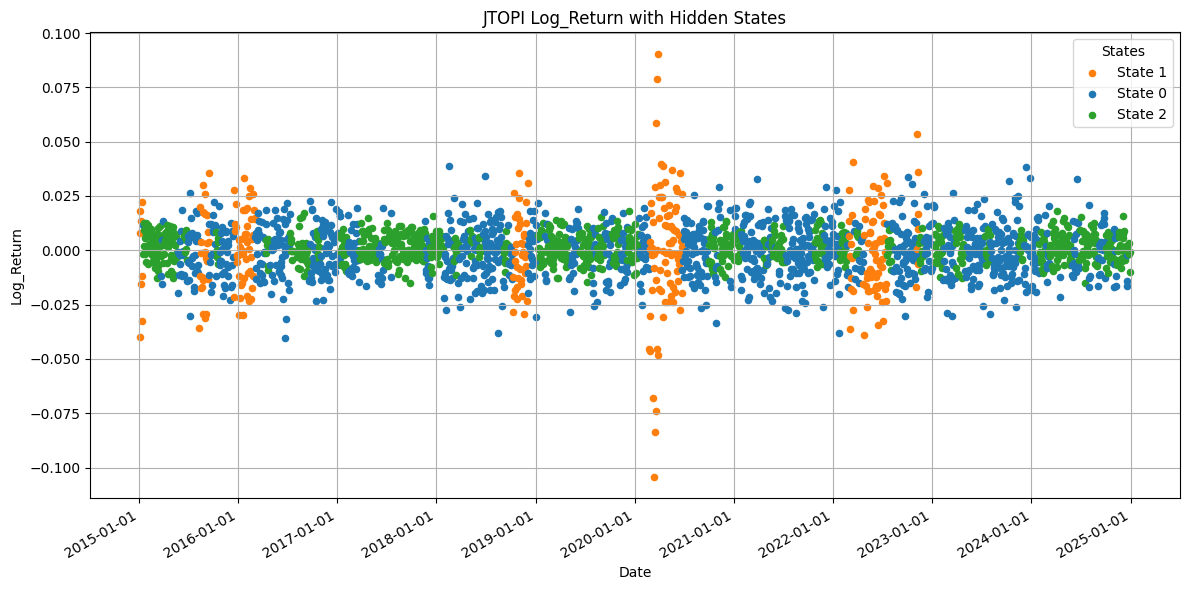

In [25]:
analysis.states_plot_points(sa40, 'Log_Return', three_state_sequence)

In [28]:
three_state_model.save_model('three_state_model')

HMM parameters saved to 'three_state_model.pkl'


#### Evaluate Model Against hmmlearn Model

In [30]:
import numpy as np
from hmmlearn import hmm

hmmlearn_three_state_model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
hmmlearn_three_state_model.fit(sa40.series_data['Log_Return'].to_numpy().reshape(-1,1))

GaussianHMM(n_components=3, n_iter=100)

In [31]:
three_state_log_likelihood = hmmlearn_three_state_model.score(sa40.series_data['Log_Return'].to_numpy().reshape(-1,1))
print(f'Akaike Information Criterion: {AIC(3, three_state_log_likelihood)}')
print(f'Bayesian Information Criterion: {BIC(3, three_state_log_likelihood)}')

Akaike Information Criterion: -15320.523566854607
Bayesian Information Criterion: -15239.201356560185


In [32]:
hmmlearn_three_state_sequence = hmmlearn_three_state_model.predict(sa40.series_data['Log_Return'].to_numpy().reshape(-1,1))

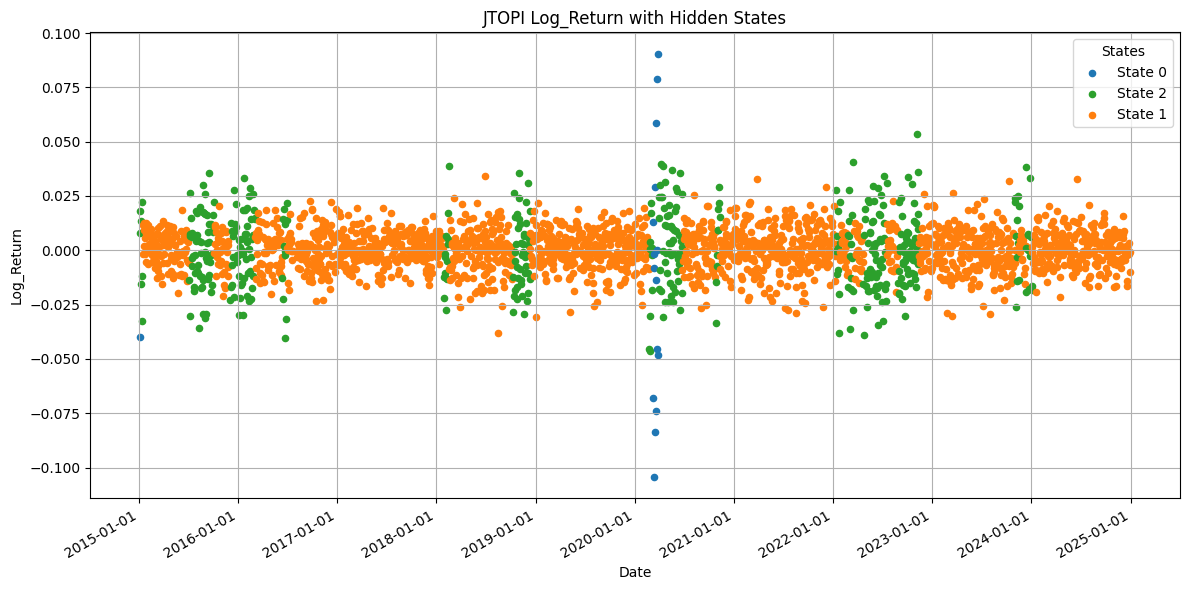

In [33]:
analysis.states_plot_points(sa40, 'Log_Return', hmmlearn_three_state_sequence)